# Diffusion From Scratch

In this notebook we will be implementing a Unet from scratch and will be diving deep into the individual parts of the model training pipeline: 
- Adding noise to the data
- The Noise Schedule
- Improvements over a simple Unet
- Differences in training objective
- Timestep conditioning
- Sampling approaches

## Setup

In [1]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


In [3]:
!git config --global credential.helper store

In [2]:
# Logging in to hugging face using tokens
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2024-07-27 18:18:48.123697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 18:18:48.123806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 18:18:48.267420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


## Loading Data

We are going to use the FashionMNIST dataset

In [5]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17703333.09it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 465357.04it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4346132.12it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2808155.77it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 6, 3, 0, 2, 8, 8, 5])


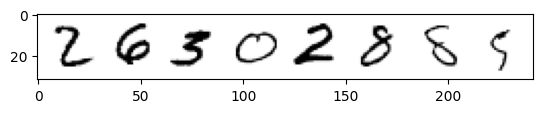

In [10]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

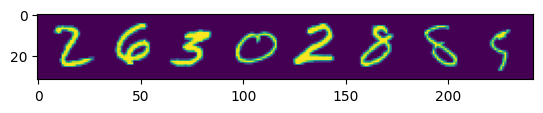

In [11]:
plt.imshow(torchvision.utils.make_grid(x)[0])

Input shape: [8, 1, 28, 28]
- Batch Size : 8
- Channel: 1
- Dimensions: 28 x 28 pixels

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## The corruption process - adding noise

Across `t` timesteps, we gradually increase noise from 0 to purely noise.

Exmaple: if `noise = torch.rand_like(x)` ,

`noisy_x = (1-t)*x + t*noise`

So when `t = 0`, the image has 0 noise and when `t = 1`, the image is entirely noise.

In [12]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

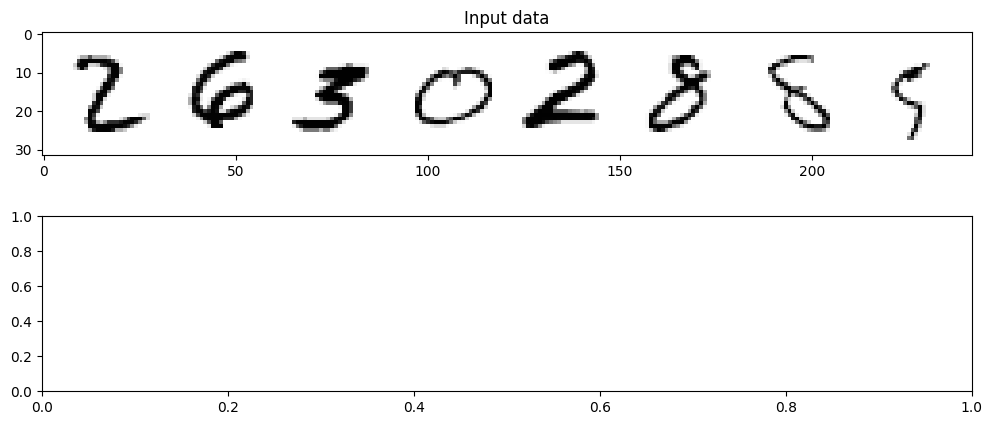

In [13]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [14]:
# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
amount

tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])

In [16]:
noised_x = corrupt(x, amount)
noised_x

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0405, 0.0791, 0.0816,  ..., 0.0808, 0.1412, 0.1265],
          [0.1235, 0.0349, 0.0548,  ..., 0.1406, 0.1048, 0.1196],
          [0.0012, 0.0029, 0.0683,  ..., 0.0481, 0.0113, 0.0335],
          ...,
          [0.1206, 0.0249, 0.1077,  ..., 0.0793, 0.0877, 0.1343],
          [0.1048, 0.0154, 0.1009,  ..., 0.1052, 0.1209, 0.0061],
          [0.0659, 0.1290, 0.1413,  ..., 0.1323, 0.0975, 0.0357]]],


        [[[0.1038, 0.1027, 0.0953,  ..., 0.1573, 0.1647, 0.1026],
          [0.1082, 0.1166, 0.2537,  ..., 0.1084, 0.0069, 0.0697],
          [0.2413, 0.2508, 0.0962,  ..

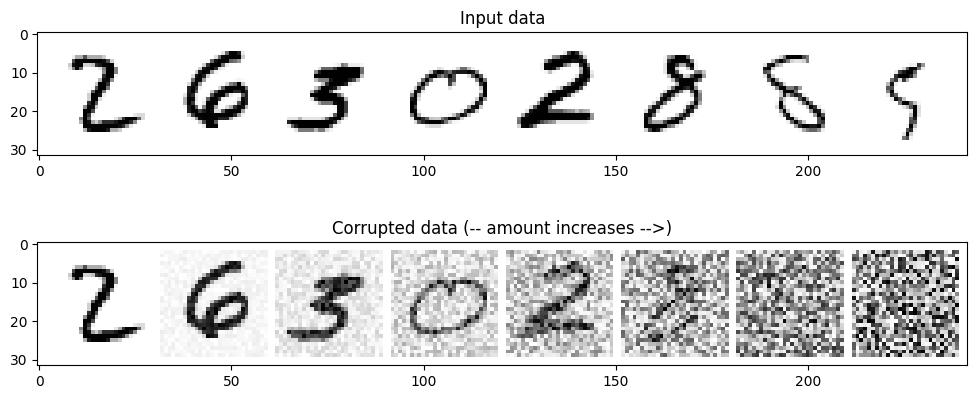

In [18]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [19]:
amount

tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])

As noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the digit fairly well. Is this optimal?